#  How to detect Social Distancing violations using AWS Panorama

**Goal of this Notebook** :

* Aid an Panorama developer prototype their application before creating the AWS Lambda for Panorama
* Creating an MXNET application in the same structure as the AWS Lambda for Panorama
* Create and Deploy the AWS Lambda for Panorama from this notebook

**What this Notebook accomplishes?** :
* Detect Distance between people in a frame
* Red Bounding Boxes are drawn for people not adhering to Social Distancing
* Green Bounding Boxes are drawn for people who are adhering to Social Distancing


**Useful Resources to aid your development**:
* [AWS Panorama Documentation](https://docs.aws.amazon.com/panorama/)


**Pre -Requisites**:
* Sagemaker Instance created with the right role (Policies needed IOT, Lambda and S3, IAM Full Access) ( Add Doc here)


**Frames to Process**:


* By default, we only process 10 frames from the video. If you want to increase this, please change this value in /panorama_sdk/panoramasdk.py and change frames_to_process = 10 to a value of your choice

----------------
### Imports
----------------

In [1]:
video_to_use = "TownCentreXVID.avi"

In [4]:
from __future__ import division
from __future__ import print_function

import os
import sys
path = os.path.abspath(os.path.join(os.path.dirname("panorama_sdk"), '../..'))
sys.path.insert(1, path + '/panorama_sdk')

import jupyter_utils

from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (20,20)

import numpy as np
import mxnet as mx
from gluoncv import model_zoo, data, utils

import cv2
import math
import boto3
import os
import json

from IPython.display import clear_output, Markdown, display
from IPython.display import display, Math, Latex, Markdown

#### Import Roles

In [5]:
import sagemaker
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

`dotdict` class is defined so we can get access to dictionary attributes with a `.`

In [6]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""

    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

----------------
### Explaining the approach
----------------

- Use a GluonCV VOC model to get all person bounding boxes
- Loop thru the bounding boxes and determine the distance between all person pairs (More on this later)
- Return distance between all people
- If distance falls below Threshold value, we return a red bounding box, else green


**Distance Calculation**

- To calculate distance , a size mask is created for the view provided by the camera
- For every area in the image that has a person in it, calculate an image distance that correspond to 6 ft
- Use the above calculation as a conversion factor to convert distances to ft

Distance Calculation Formula

- Taking the Top and Left bounding box coordinates of each person identified, we calculate the following between two people A and B

$$distance = \sqrt(({TopB - TopA}^2) - ({LeftB - LeftA}^2))$$








This below picture gives a great example

![Distance Calc4](DistanceCalc4.png)

----------------
### Main Function
----------------

**Note**: 

* The code structure below is as close to the lambda structure as possible, but is **NOT** the actual Lambda.

* To see and compare the actual lambda to this code, please open the HandWashDetection.py file in the Lambda folder.

The Panorama Lambda function has the following structure

**Tip** : Actual Lambda inherits base class called panoramasdk.base instead of object

In [7]:
### Lambda skeleton


class AwsPanoramaSD(object):
    def interface(self):
        # defines the parameters that interface with other services from Panorama
        return

    def init(self, parameters, inputs, outputs):
        # defines the attributes such as arrays and model objects that will be used in the application
        return

    def entry(self, inputs, outputs):
        # defines the application logic responsible for predicting using the inputs and handles what to do
        # with the outputs
        return

**More Notes**:

- This runs only for 20 frames for now, if you want to change that, please change the self.num_frames in the init function. 

- This is not the case with the actual lambda

In [8]:
jupyter_utils.change_video_source(video_to_use)

Video Changed to TownCentreXVID.avi


In [9]:
import panoramasdk
import cv2
import numpy as np
import time
import boto3
import math 
import datetime


# SD based imports
import ModelOutput as jm
import socialDistance as sd
import socialDistanceUtils as sdu

red    = (0,0,255)
green  = (0,255,0)
black  = (0,0,0)
white  = (255,255,255)
text_color = black

num_frames = 1000000000
mask_frequency = 10


HEIGHT = 512
WIDTH = 512

class AwsPanoramaSD(panoramasdk.base):
    
    def interface(self):
        return {
                "parameters":
                (
                    ("model", "person_detection", "Model for detecting persons", "ssd_512_resnet50_v1_voc"), 
                    ("float", "threshold", "Detection threshold", 0.10),
                    ("int", "batch_size", "Model batch size", 1),
                    ("float", "person_index", "person index based on dataset used", 14)
                ),
                "inputs":
                (
                    ("media[]", "video_in", "Camera input stream"),
                ),
                "outputs":
                (
                    ("media[video_in]", "video_out", "Camera output stream"),
                    
                ) 
            }
        
    def init(self, parameters, inputs, outputs):
        
        try:
        
            print('Loading Model')
            self.model = panoramasdk.model()
            self.model.open(parameters.person_detection, 1)
            print('Model Loaded')

            # Detection probability threshold.
            self.threshold = parameters.threshold

            # Frame Number Initialization
            self.frame_num = 0

            # Number of People
            self.number_people = 0

            # Bounding Box Colors
            self.colours = np.random.rand(32, 3)

            # Person Index for Model from parameters
            self.person_index = parameters.person_index

            
            self.boxes = []
            self.frame_num = 0
            self.send_images = True
            
            # SD Code 2
            self._batch_frame_count = 0
            self._frame_count = 0
            self._cam_standing_people = []
            self._curr_refs = []
            self._total_size_mask_count = 0
            self._cam_left = -1
            self._size_mask = []
            self.mask_frequency = 10
            self.num_frames = 20

            # Create input and output arrays.
            class_info = self.model.get_output(0)
            prob_info = self.model.get_output(1)
            rect_info = self.model.get_output(2)

            self.class_array = np.empty(class_info.get_dims(), dtype=class_info.get_type())
            self.prob_array = np.empty(prob_info.get_dims(), dtype=prob_info.get_type())
            self.rect_array = np.empty(rect_info.get_dims(), dtype=rect_info.get_type())

            return True
        
        except Exception as e:
            print("Exception: {}".format(e))
            return False

    def preprocess(self, img, size):
        
        resized = cv2.resize(img, (size, size))
        mean = [0.485, 0.456, 0.406]  # RGB
        std = [0.229, 0.224, 0.225]  # RGB
        
        img = resized.astype(np.float32) / 255.  # converting array of ints to floats
        img_a = img[:, :, 0]
        img_b = img[:, :, 1]
        img_c = img[:, :, 2]
        
        # Extracting single channels from 3 channel image
        # The above code could also be replaced with cv2.split(img) << which will return 3 numpy arrays (using opencv)
        # normalizing per channel data:
        img_a = (img_a - mean[0]) / std[0]
        img_b = (img_b - mean[1]) / std[1]
        img_c = (img_c - mean[2]) / std[2]
        
        # putting the 3 channels back together:
        x1 = [[[], [], []]]
        x1[0][0] = img_a
        x1[0][1] = img_b
        x1[0][2] = img_c
        x1 = np.asarray(x1)
        
        return x1
    
    def get_number_persons(self, class_data, prob_data):
        
        # get indices of people detections in class data
        person_indices = [i for i in range(len(class_data)) if int(class_data[i]) == self.person_index]
        # use these indices to filter out anything that is less than 95% threshold from prob_data
        prob_person_indices = [i for i in person_indices if prob_data[i] >= self.threshold]
        return prob_person_indices
    
    
    def blur_bounding_box(self, person_image, bbox,sigma = 3.5): 
        img = person_image
        img_arr = img.copy()
        img_w, img_h = img.shape[1],img.shape[0]
        nominal_box_area = img_h * img_w * 0.1
        blur_sigma = sigma
        for boxes in bbox:
            try:
                xmin, ymin, xmax, ymax = [int(x) for x in boxes]
                print('BBox input into function {}'.format([xmin, ymin, xmax, ymax]))
                ymin = int(((ymin/512.0)*img_h))
                xmin = int(((xmin/512.0)*img_w))
                ymax = int(((ymax/512.0)*img_h))
                xmax = int(((xmax/512.0)*img_w))
                print('BBox input into function after scaling {}'.format([xmin, ymin, xmax, ymax]))    
                # blurring 
                box_area = (xmax - xmin) * (ymax - ymin)
                sigma_scaled = blur_sigma * math.sqrt(box_area/nominal_box_area)
                sigma_clamped = min(5.5, max(1.0, sigma_scaled))
                bbox_img = img_arr[ymin:ymax, xmin:xmax, :]
                img_arr[ymin:ymax, xmin:xmax, :] = cv2.GaussianBlur(bbox_img, (0, 0), sigma_clamped)
            except Exception as e:
                pass
        return img_arr
        

    def different_enough(self, a, b):
        try:
            a_bb = a['BoundingBox']
            b_bb = b['BoundingBox']
        
            h_diff = abs(a_bb['Height'] - b_bb['Height'])
            w_diff = abs(a_bb['Width']  - b_bb['Width'])
            t_diff = abs(a_bb['Top']    - b_bb['Top'])
            l_diff = abs(a_bb['Left']   - b_bb['Left'])
        
            total_other_diff = h_diff + w_diff + l_diff
            if (t_diff > 0.10) and (total_other_diff > 0.30):
                return True
            else:
                return False
        except Exception as e:
            print('Different enough exception is {}'.format(e))
            return False
    
    def add_distinct_people(self, all_people, new_people):
        if len(all_people) == 0:
            return new_people 
        else:
            tmp_people = all_people.copy()
            for np in new_people:
                is_diff = False
                for ap in all_people:
                    is_this_one_diff = self.different_enough(np, ap)
                    if is_this_one_diff:
                        is_diff = True
                        break
                if is_diff:
                    tmp_people.append(np)
            return tmp_people

    
    def entry(self, inputs, outputs):

        for i in range(len(inputs.video_in)):
            stream = inputs.video_in[i]
            person_image = stream.image
            w, h, c = person_image.shape
            
            sending_image = person_image.copy()
            redacted_image = person_image.copy()
                
             # SD Code 1
            _frame = person_image.copy()
            _image_shape, _size_mask_shape = sdu.get_shapes(_frame)
                        

            # Pre Process Frame
            x1 = self.preprocess(person_image, 512)
                                    
            # Do inference on the new frame.
            self.model.batch(0, x1)
            self.model.flush()
            
            # Get the results.
            resultBatchSet = self.model.get_result()
            
            class_batch = resultBatchSet.get(0)
            prob_batch = resultBatchSet.get(1)
            rect_batch = resultBatchSet.get(2)

            class_batch.get(0, self.class_array)
            prob_batch.get(1, self.prob_array)
            rect_batch.get(2, self.rect_array)

            class_data = self.class_array[0]
            prob_data = self.prob_array[0]
            rect_data = self.rect_array[0]
            
            
            class_data2 = self.class_array
            prob_data2 = self.prob_array
            rect_data2 = self.rect_array               

            person_indices = self.get_number_persons(class_data,prob_data)

            # find people in this frame
            _img_all_people, _img_standing_people = sdu.get_standing_people(_frame, _image_shape, _size_mask_shape, x1, class_data2, prob_data2, rect_data2)
            _num_total_people = len(_img_all_people)
            _min_distance = sd.MAX_DISTANCE
            _safe_cat = 'LessThanTwoPeople'
            
            
            # every N seconds, if we still need a better size mask, try to improve it
            if self._batch_frame_count < mask_frequency:
                self._batch_frame_count += 1
                
            elif (len(self._cam_standing_people) < sdu.MAX_STANDING_REFS_NEEDED) or (self._total_size_mask_count == 0):
                self._batch_frame_count = 0
                # 1. add to cumulative list of standing people for this camera
                self._cam_standing_people = self.add_distinct_people(self._cam_standing_people, _img_standing_people)
                # 2. once we have at least MIN_STANDING_REFS_PER_CAM people in our running list
                if (len(self._cam_standing_people) > sdu.MIN_STANDING_REFS_PER_CAM):
                    # 2a. generate the best size mask for the standing people thus far
                    _curr_camera_config, _curr_best_rmse, _curr_size_mask_count = \
                        sdu.gen_best_size_mask(self._cam_standing_people, _image_shape, _size_mask_shape)

                    if _curr_size_mask_count > 0:
                        self._curr_refs = _curr_camera_config['MaskReferenceSizes']
                    self._total_size_mask_count += _curr_size_mask_count

                    #print('total masks: {}, latest rmse: {}, refs: {}'.format(self._total_size_mask_count[i],_curr_best_rmse,self._curr_refs[i]))
                    if _curr_size_mask_count > 0:
                        self._cam_left   = _curr_camera_config['CameraLeft']
                        _cam_height = _curr_camera_config['CameraHeight']
                        self._size_mask = np.asarray(_curr_camera_config['SizeMask'])

                                    
            if (self._total_size_mask_count > 0):
                _verbose = False
                _likely_people, _proximity_list = sd.detect_distances(_img_all_people, self._size_mask, _image_shape,
                                                                      _cam_height, _verbose)
                _min_distance     = sdu.min_distance_from_list(_proximity_list)
                _num_unsafe_pairs = sdu.get_num_unsafe_pairs(_proximity_list)
                _num_total_people = len(_likely_people)

                if _num_total_people < 2:
                    _safe_cat = 'LessThanTwoPeople'
                elif _min_distance > sdu.MIN_SAFE_DISTANCE:
                    _safe_cat = 'AppropriateDistance'
                else:
                    _safe_cat = 'ReducedDistance'

            
            else:
                _proximity_list = [] 
                self._curr_refs      = []
                _likely_people  = []
                self._curr_refs.append({'HeightImageRatio': 0, 'AspectRatio': 0, 'FromImage': '', 'GridPos': [0,0]})
                self._curr_refs.append({'HeightImageRatio': 0, 'AspectRatio': 0, 'FromImage': '', 'GridPos': [0,0]})
            


            # update saftey banner at bottom of output stream
            #   green banner if safe, red if unsafe, count of people in the frame
            
            if _safe_cat in ['LessThanTwoPeople', 'AppropriateDistance']:
                color = green
                text_color = black
            else:
                color = red
                text_color = white
                
            # Draw a color-coded banner at the bottom of the frame showing safety, num people, min distance
            cv2.rectangle(stream.image, (0, _frame.shape[0] - 30), (_frame.shape[1], _frame.shape[0]), color, -1)
            
            if (_min_distance >= sd.MAX_DISTANCE):
                banner_text = '{} people'.format(_num_total_people)
            else:
                banner_text = '{}, {} people, Min: {} ft'.format(_safe_cat, _num_total_people, _min_distance)

            cv2.putText(stream.image, banner_text, 
                        (20, _frame.shape[0] - 10), cv2.FONT_HERSHEY_COMPLEX_SMALL, #SIMPLEX, 
                        1, text_color, 1, cv2.LINE_AA)

            
            # overlay color-coded bounding boxes on output stream, including yellow boxes for reference people
            sdu.add_bboxes(stream.image, _likely_people, _proximity_list, self._curr_refs, _size_mask_shape)  
            stream.image = cv2.cvtColor(stream.image, cv2.COLOR_BGR2RGB)
            
            self._frame_count += 1
            
            self.model.release_result(resultBatchSet)
            outputs.video_out[i] = stream

            
        return True
            
            
        
            

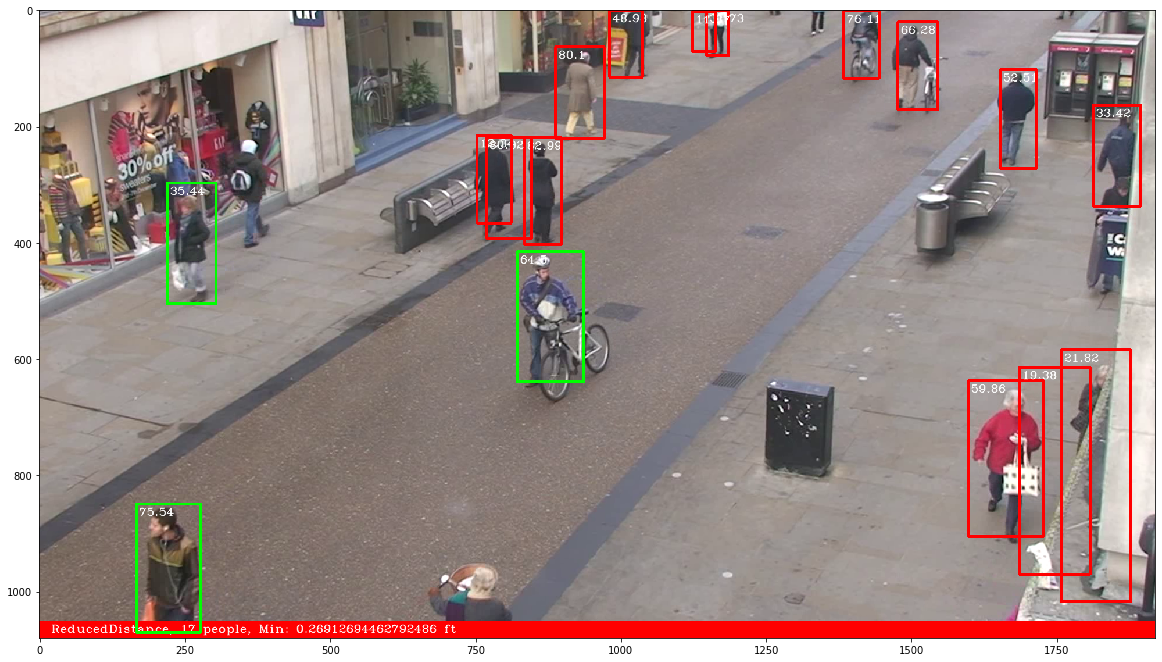

In [10]:
def main():
    AwsPanoramaSD().run()


main()

----------------
### Known Issues
----------------

- Person Detector does not detect everyone in the frame
    - Can result in False Negative SD violations
    - Less reliable on people faraway from the camera
    
    

- Person Detector sometime identifies non people as people
    - This can also result in False Negative SD violations


----------------
### Upload Lambda and Create Lambda Function 
----------------

* A lambda is already provided and ready for use in the lambda folder (zip file)
* Use this code snippet to upload and publish it to Lambda Service

This Python snippet uses boto3 to create an IAM role named LambdaBasicExecution_SD_demo with basic 
lambda execution permissions.

In [13]:
role_policy_document = {
    "Version": "2012-10-17",
    "Statement":[
        {
            "Effect": "Allow",
            "Principal": {"Service": ["lambda.amazonaws.com", "events.amazonaws.com"]},
            "Action": "sts:AssumeRole",
        }
    ]
}


iam_client = boto3.client("iam")

iam_client.create_role(
    RoleName="SDExecutionRole",
    AssumeRolePolicyDocument=json.dumps(role_policy_document),
)

{'Role': {'Path': '/',
  'RoleName': 'SDExecutionRole1',
  'RoleId': 'AROAZAPJMVFPPB4XGOHGJ',
  'Arn': 'arn:aws:iam::619501627742:role/SDExecutionRole1',
  'CreateDate': datetime.datetime(2020, 11, 19, 20, 50, 40, tzinfo=tzlocal()),
  'AssumeRolePolicyDocument': {'Version': '2012-10-17',
   'Statement': [{'Effect': 'Allow',
     'Principal': {'Service': ['lambda.amazonaws.com',
       'events.amazonaws.com']},
     'Action': 'sts:AssumeRole'}]}},
 'ResponseMetadata': {'RequestId': '4630f654-2ee1-4fe3-aa61-3a6ff3cfc6ac',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '4630f654-2ee1-4fe3-aa61-3a6ff3cfc6ac',
   'content-type': 'text/xml',
   'content-length': '824',
   'date': 'Thu, 19 Nov 2020 20:50:39 GMT'},
  'RetryAttempts': 0}}

The following Python snippet will use the resources above to create a new AWS Lambda function called SocialDistancing_demo

In [11]:
!zip -o  ../Lambda/SocialDistanceDetection.zip  ../Lambda/lambda_function.py ../Lambda/lModelOutput.py ../Lambda/socialDistance.py ../Lambda/socialDistanceUtils.py  

	zip warning: name not matched: ../Lambda/lModelOutput.py
  adding: ../Lambda/lambda_function.py (deflated 73%)
  adding: ../Lambda/socialDistance.py (deflated 73%)
  adding: ../Lambda/socialDistanceUtils.py (deflated 75%)


In [15]:
lambda_client = boto3.client("lambda")

with open("../Lambda/SocialDistanceDetection.zip", "rb") as f:
    zipped_code = f.read()

role = iam_client.get_role(RoleName="SDExecutionRole")
response_create_function = lambda_client.create_function(
    FunctionName="SocialDistancingLambda",
    Runtime="python3.7",
    Role=role["Role"]["Arn"],
    Handler="lambda_function.main()",
    Code=dict(ZipFile=zipped_code),
    Timeout=120,
    MemorySize=2048,
)

**What is an ARN?** : Amazon Resource Names (ARNs) uniquely identify AWS resources.

The following Python snippet will publish the Lambda Function that was created above, and return an ARN with a version. 

This version arn can be used to go directly to the Panorama console and deploy this application.

In [25]:
response = lambda_client.publish_version(FunctionName="SocialDistancingLambda")

Printing the details of the lambda function that was just published

In [26]:
function_arn = response["FunctionArn"]
function_arn_version = list(response["FunctionArn"].split(":"))[-1]
lambda_url = (
    "https://console.aws.amazon.com/lambda/home?region=us-east-1#/functions/"
    + response["FunctionName"]
    + "/versions/"
    + response["Version"]
    + "?tab=configuration"
)

----------------------------
### Upload tar.gz file to an S3 bucket
----------------------------

In [18]:
def printmd(string, color=None):
    """
    Helper Function for Fomatting Output
    """
    colorstr = "<span style='color:{}'>{}</span>".format(color, string)
    display(Markdown(colorstr))
    

In [19]:
def send_model_to_s3(model, bucket = 'aws-panorama-models-bucket'):
    s3 = boto3.resource('s3')
    s3.create_bucket(Bucket=bucket)
    
    key = '../../Models/' + model
    
    s3.Object(bucket, model).put(Body=open(key, 'rb'))
    
    bucket_name = bucket
    
    
    location = boto3.client('s3').get_bucket_location(Bucket='aws-panorama-models-bucket')['LocationConstraint']
    url = "s3://{}/{}".format(bucket_name, model)
    
    printmd("**S3 Path** : **{}**".format(url), color="black")
    
    return

In [20]:
send_model_to_s3(model = 'ssd_512_resnet50_v1_voc.tar.gz')

<span style='color:black'>**S3 Path** : **s3://aws-panorama-models-bucket/ssd_512_resnet50_v1_voc.tar.gz**</span>

----------------------------
### Next steps
----------------------------

The Lambda is now created and published. You are now ready to deploy your model and the published lambda function, to the Manhattan Panorama device

The instructions to deploy are linked below

[Creating Application Instructions Here](https://docs.aws.amazon.com/panorama/)

##### Some helpful information about the Lambda

In [30]:
printmd("**Function Arn** : **{}**".format(function_arn), color="black")
printmd("**Function Arn Version** : **{}**".format(function_arn_version), color="black")
printmd("**Lambda Console Link** : **{}**".format(lambda_url), color="black")

<span style='color:black'>**Function Arn** : **arn:aws:lambda:us-east-1:619501627742:function:SocialDistancingLambda:2**</span>

<span style='color:black'>**Function Arn Version** : **2**</span>

<span style='color:black'>**Lambda Console Link** : **https://console.aws.amazon.com/lambda/home?region=us-east-1#/functions/SocialDistancingLambda/versions/2?tab=configuration**</span>

In [26]:
printmd("**Inputs**", color="black")
print('     ')
printmd("**Input Name** : **{}**".format('data'), color="black")
printmd("**Shape** : **{}**".format([1,3,512,512]), color="black")
printmd("**Order** : **{}**".format('NCHW'), color="black")
printmd("**FourCC** : **{}**".format('BGR3'), color="black")
printmd("**Normalize** : **{}**".format('minmax'), color="black")
printmd("**Minmax range** : **{}**".format('[0,255]'), color="black")


<span style='color:black'>**Inputs**</span>

<span style='color:black'>**Input Name** : **data**</span>

<span style='color:black'>**Shape** : **[1, 3, 512, 512]**</span>

<span style='color:black'>**Order** : **NCHW**</span>

<span style='color:black'>**FourCC** : **BGR3**</span>

<span style='color:black'>**Normalize** : **minmax**</span>

<span style='color:black'>**Minmax range** : **[0,255]**</span>

In [27]:
printmd("**Outputs**", color="black")
print("     ")
printmd("**Output0**", color="black")
printmd("**Output Name** : **{}**".format("NMS"), color="black")
printmd("**Shape** : **{}**".format("[1,1,100,1]"), color="black")
print("     ")
printmd("**Output1**", color="black")
printmd("**Output Name** : **{}**".format("NMS1"), color="black")
printmd("**Shape** : **{}**".format("[1,1,100,1]"), color="black")
print("     ")
printmd("**Output2**", color="black")
printmd("**Output Name** : **{}**".format("NMS2"), color="black")
printmd("**Shape** : **{}**".format("[1,1,100,4]"), color="black")

<span style='color:black'>**Outputs**</span>

<span style='color:black'>**Output0**</span>

<span style='color:black'>**Output Name** : **NMS**</span>

<span style='color:black'>**Shape** : **[1,1,100,1]**</span>

<span style='color:black'>**Output1**</span>

<span style='color:black'>**Output Name** : **NMS1**</span>

<span style='color:black'>**Shape** : **[1,1,100,1]**</span>

<span style='color:black'>**Output2**</span>

<span style='color:black'>**Output Name** : **NMS2**</span>

<span style='color:black'>**Shape** : **[1,1,100,4]**</span>